# Phase response curve

In [1]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore, QtGui
from sklearn.linear_model import LinearRegression
import numpy as np
import os,sys
from statsmodels.regression import linear_model as sm
import statsmodels.api as sm2
%matplotlib inline
import matplotlib.cm as cm
cmap = cm.tab10
import random
from scipy import signal
import cmath
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore, QtGui
from sklearn.linear_model import LinearRegression
import numpy as np
import os,sys
from statsmodels.regression import linear_model as sm
import statsmodels.api as sm2
%matplotlib inline
import matplotlib.cm as cm
cmap = cm.tab10
import random
from scipy import signal
import cmath
%load_ext autoreload
%autoreload 2
from scipy.signal import firwin, lfilter, filtfilt
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.path import Path
from matplotlib import patches
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLineCollection
import numpy as np
# questo lo usi se vuoi definire qualche colormap personalizzata, questa per esempio
# va dal blu all'arancione
colorss = ["navy", "royalblue", "cornflowerblue", "lightsalmon", "coral", "orangered", "firebrick"]
nodes = [0.0, 1/6, 1/3, 1/2, 2/3, 5/6, 1]
my_cmap = LinearSegmentedColormap.from_list("my_cmap", list(zip(nodes, colorss)))

class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator

colors = ["navy", "royalblue", "cornflowerblue", "lightsalmon", "coral", "orangered", "firebrick"]
nodes = [0.0, 1/6, 1/3, 1/2, 2/3, 5/6, 1]
my_cmap = LinearSegmentedColormap.from_list("my_cmap", list(zip(nodes, colors)))

/home/benny/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [35]:
# va definita tra pi greco e meno pi greco??? la differenza di fase
# phase response curve la si calcola a livello di singolo segnale?

In [2]:
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20

In [3]:
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern'
plt.rcParams['text.usetex'] = True

In [5]:
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

In [7]:
cd '/home/benny/Desktop/Github/Criticality-in-barrel-cortex'

/home/benny/Desktop/Github/Criticality-in-barrel-cortex


In [8]:
from valanghe import *
%load_ext autoreload
%autoreload 2
from modules_plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
cd '/home/benny/Desktop/Github/Oscillations analysis'

/home/benny/Desktop/Github/Oscillations analysis


In [10]:
def R_helper_detector_LFP(_input):
    maxima=[]
    for i in range(1, len(_input)-1):
        if (_input[i-1] < _input[i] and _input[i] > _input[i+1]) and _input[i] > np.median(_input) : 
                maxima.append([i, _input[i]])
    maxima = np.array(maxima)
    return(maxima)

In [11]:
def R_helper_detector(_input):
    maxima=[]
    for i in range(1, len(_input)-1):
        if (_input[i-1] < _input[i] and _input[i] > _input[i+1]) and _input[i] > 0.98 : 
                maxima.append([i, _input[i]])
    maxima = np.array(maxima)
    return(maxima)
           


def plot_maxima(R_peaks, filtered_signal):
    fig_M, ax_M = plt.subplots(1, 1, figsize=(8,6))
    fig_M.suptitle("Maxima Visualization", size = 'x-large', weight = "bold")
    
    ax_M.set_xlabel("index[n]")
    ax_M.set_ylabel("Amplitude")
    #selected interval to show maxima in the plot
    bound2 = [100000,102000]
    
    currM = R_peaks[R_peaks[:,0]<bound2[1], :]
    currM = currM[currM[:,0]>bound2[0], :]
    
    ax_M.scatter(range(bound2[0], bound2[1]), filtered_signal[bound2[0]:bound2[1]], s=1)
    ax_M.scatter(currM[:,0], currM[:,1], s=9, c='red')

In [12]:
def my_moving_window(x, window=3, FUN=np.mean):
    """
    Calculates a moving estimate for a signal

    Args:
      x (numpy.ndarray): a vector array of size N
      window (int): size of the window, must be a positive integer
      FUN (function): the function to apply to the samples in the window
    Returns:
      (numpy.ndarray): a vector array of size N, containing the moving
      average of x, calculated with a window of size window
    """
    if len(x.shape) == 2:
        output = np.zeros(x.shape)
        for rown in range(x.shape[0]):
            output[rown, :] = my_moving_window(x[rown, :],window=window,FUN=FUN)                       
        return output
    output = np.zeros(x.size)
    for samp_i in range(x.size):
        values = []
        # loop through the window:
        for wind_i in range(int(1 - window), 1):
            if ((samp_i + wind_i) < 0) or (samp_i + wind_i) > (x.size - 1):
                # out of range
                continue
            # sample is in range and not nan, use it:
            if not(np.isnan(x[samp_i + wind_i])):
                values += [x[samp_i + wind_i]]
        # calculate the mean in the window for this point in the output:
        output[samp_i] = FUN(values)
    return output


In [30]:
cd /home/benny/Desktop/altriDati/20180531_4x64/2s

/home/benny/Desktop/altriDati/20180531_4x64/2s


In [70]:
cd /home/benny/Desktop/altriDati/20181024_4x64/2s

/home/benny/Desktop/altriDati/20181024_4x64/2s


In [13]:
cd /home/benny/Desktop/Benedetta/20180530_4x64/ISI_2s/

/home/benny/Desktop/Benedetta/20180530_4x64/ISI_2s


In [14]:
lista = np.sort(os.listdir())

In [15]:
timeseries =[]
for k in range(20):
    #print(lista[k])
    
    if "bin" in lista[k]:
        path = lista[k]
        width = 4    #columns
        heigth = 64   #rows
        nframes = 2000  #load  only some frames
        #n_words_to_load = heigth * width  * nframes
        n_words_to_load = -1  #load  all frames 
        raw = np.fromfile( path, dtype=np.double, count = n_words_to_load)  # count = -1 to load all data
        a = np.reshape(raw, (-1, width, heigth))
        a1 = []

        for z in range(9764):
            a1.append(np.delete(a[z],(0,1,2,3,4,5,6,7,8), axis = 1).transpose().tolist())

        a1 = np.asarray(a1)
        a1 = a1.reshape(-1,220)
        timeseries.append(a1)
    
                      
timeseries = np.array(timeseries)
timeseries[:,:,60] = np.mean(timeseries, axis = 2)

In [25]:
dt = 10/9764
sf = 1/dt

down = 1
up = 100
nyq = 0.5*sf

lowcut = 10 - 1
highcut = 10 + 1
low = lowcut / nyq
high = highcut / nyq
order = 2


sig = timeseries[:,:,:]

n = 100
Wn = [lowcut,highcut]
b = firwin(n, Wn,pass_zero=False,fs = sf) 
filtered2  = filtfilt(b, 1, sig,axis = 1)
f, h = signal.butter(order,[low, high], btype='bandpass')
filtered = signal.filtfilt(f, h, sig, axis = 1,padlen=150)

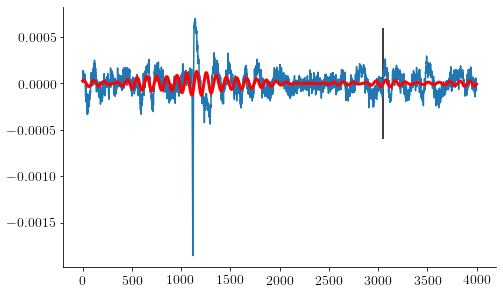

In [26]:
t_s = 3051
plt.plot(timeseries[3,1000:5000,61])
plt.plot(filtered[3,1000:5000,61], lw = 3, color ='r')
plt.vlines(t_s, -0.0006,0.0006,'k')

In [187]:
# farlo con dataset su 4 seconds

In [188]:
4149.504*9764/10000

4051.5757056

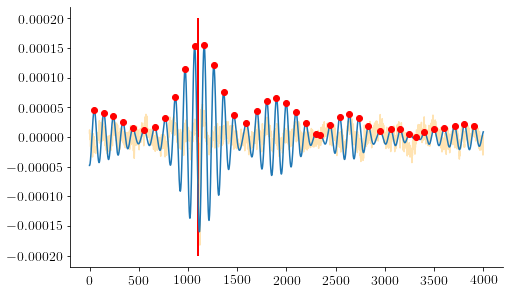

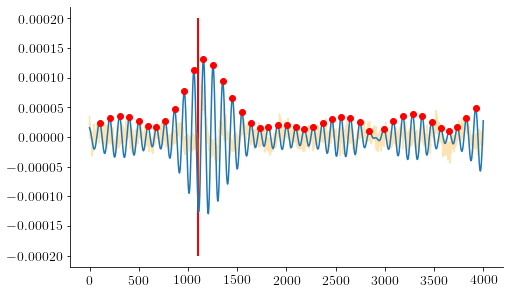

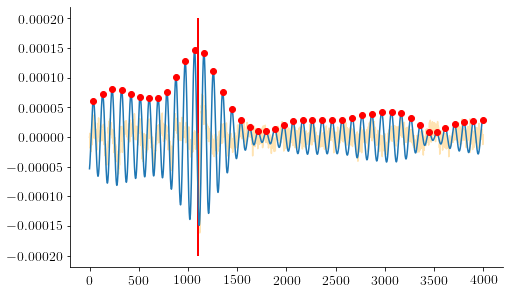

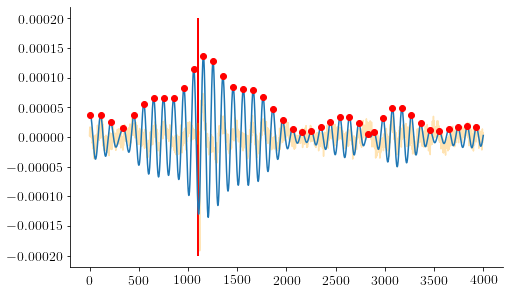

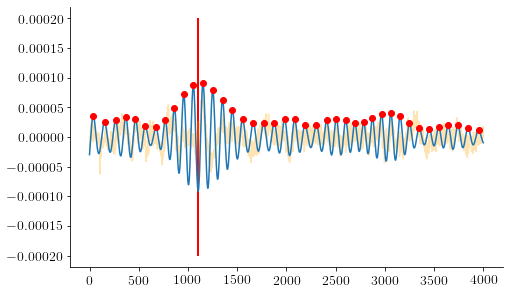

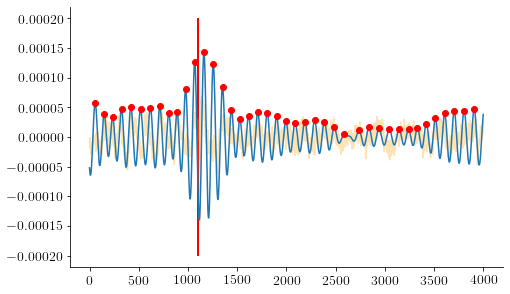

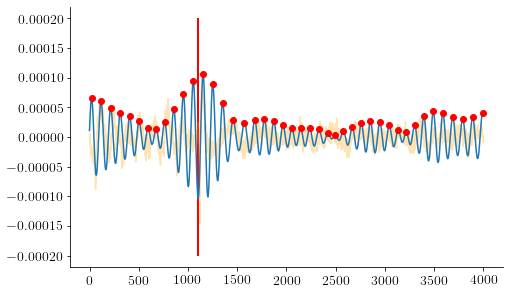

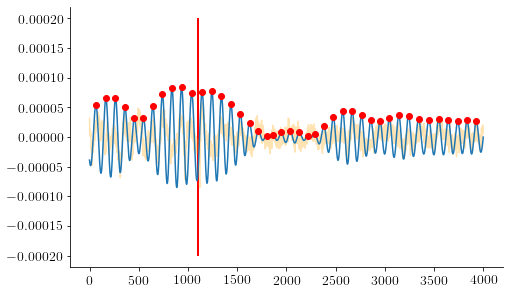

In [27]:
phasestim = []
phases = []
t_s = 1099
#t_s = 3051
o = 0
for elect in range(47,85):
    for trial in range(20):
        peaks =R_helper_detector_LFP(filtered[trial,1000:5000,elect])
        #print(peaks.shape)
        
        if elect == 62 and trial < 8:
            plt.figure()
            plt.plot(timeseries[trial,1000:5000,elect]*10**-1, 'orange', alpha = 0.3)
            plt.plot(filtered[trial,1000:5000, elect])
            plt.plot(peaks[:,0],peaks[:,1], 'ro')
            plt.vlines(t_s,-0.0002,0.0002, 'r', lw = 2)
            #plt.xlim(1000,1500)
        
        
        idx = np.where( (t_s- peaks[:,0]) == (t_s- peaks[:,0])[(t_s- peaks[:,0])>0].min())[0][0]
        time = peaks[:,0][idx]
        ts = t_s - time
        #t_s = 1110
        T0 =[]
        for r in range(len(peaks[:idx])):
            #print(len(peaks[:idx-1]))
            T0.append(peaks[:,0][idx-r] - peaks[:,0][idx -1-r])
            
        T0 = np.array(T0).mean()
        T1 = peaks[:,0][idx + 1] - peaks[:,0][idx]
        phase = (T0 - T1)/T0*2*np.pi
        phase_stim = ts/T0*2*np.pi
        if phase_stim > 2*np.pi: o+= 1
        f1 = np.sign(phase_stim)*(np.abs(phase_stim))%(2*np.pi)
        #print(phase_stim)
        #print(np.angle(np.exp(1j*phase_stim)) + np.pi, np.sign(phase_stim)*(np.abs(phase_stim))%(2*np.pi))
        phasestim.append(f1)
        #f2 = np.sign(phase)*(np.abs(phase))
        phases.append(np.angle(np.exp(1j*phase)))
        """
        if f2 > np.pi:
            phases.append(f2 - 2*np.pi)
        elif f2 < -np.pi:
            phases.append(f2 + 2*np.pi)
        else:
            phases.append(f2)
        """

In [190]:
192/20

9.6

In [191]:
# attenzione perché becco l'oscillazione anche dovuta alla stimolazione,

In [192]:
import numpy as np
np.angle(np.exp(1j*(-5.5)))

0.7831853071795865

In [28]:
plt.rcParams["axes.labelsize"] = 26
plt.rcParams["xtick.labelsize"] = 26
plt.rcParams["ytick.labelsize"] = 26

In [31]:
phases = np.array(phases)
phasestim = np.array(phasestim)
phases = phases[np.argsort(phasestim)]
phasestim = np.sort(phasestim)
for g in range(len(phasestim)):
    phasestim[g] = round(phasestim[g],3)
uni = np.unique(phasestim)
uniphases = [[] for r in range(len(uni))]
for l in range(len(uni)):
    for r in range(len(phases)):
        if phasestim[r] == uni[l]:
            uniphases[l].append(phases[r])

In [32]:
means = []
stds =[]
for r in range(len(uniphases)):
    means.append(np.mean(uniphases[r]))
    stds.append(np.std(uniphases[r])/np.sqrt(len(uniphases[r])))    

In [33]:
means,stds = np.array(means), np.array(stds)
#uniphases = np.array(uniphases)

In [37]:
mean = my_moving_window(means,5)
std = my_moving_window(stds,5)
unii = my_moving_window(uni,5)

deriv = []
for r in range(len(filtered[0,:-3,61])):
    deriv.append((filtered[0,r + 3,61] - filtered[0,r,61])/3)

x = filtered[0,:-3,61]
plt.plot(x[6000:],deriv[6000:],'r-')
plt.xlabel('x')
plt.ylabel('dx/dt')


deriv = []
for r in range(len(timeseries[0,:-3,61])):
    deriv.append((timeseries[0,r + 3,61] - filtered[0,r,61])/3)

x = filtered[0,2000:4000,61]
plt.plot(x,deriv[2000:4000],'r-')
plt.xlabel('x')
plt.ylabel('dx/dt')



#plt.plot(unii[::],mean[::], color = 'darkred')
plt.scatter(unii[::],mean[::], color = 'white', marker = 'o', s = 100,linewidths=2, edgecolors= 'darkred', alpha = 1)
plt.xticks(np.arange(0,2*np.pi + np.pi/2,np.pi/2), labels = ["0", "$\pi/2$","$\pi$","$3/2\pi$","$2\pi$"])
plt.yticks(np.arange(-np.pi,np.pi + np.pi/2,np.pi/2), labels = ["$-\pi$","$\pi/2$","$0$","$\pi/2$","$\pi$"])
plt.xlabel('Phase at stimulation time')
plt.ylabel(r'$\Delta \phi$');

#1/(T0*10**-3), 1/(T1*10**-3)
plt.plot(unii[::],mean[::], color = 'darkred', lw = 5)
plt.scatter(uni[::],means[::], color = 'red', marker = 'o', s = 100, edgecolors= 'white')
plt.xticks(np.arange(0,2*np.pi + np.pi/2,np.pi/2), labels = ["0", "$\pi/2$","$\pi$","$3/2\pi$","$2\pi$"])
plt.yticks(np.arange(-np.pi,np.pi + np.pi/2,np.pi/2), labels = ["$-\pi$","$\pi/2$","$0$","$\pi/2$","$\pi$"])
plt.xlabel('Phase at stimulation time')
plt.ylabel(r'$\Delta \phi$');

## Fit of Fourier Coefficients

In [38]:
y = np.array(means)

oss01 = np.ones((len(uni)))
oss1 = np.cos(uni)
oss2 = np.cos(2*uni)
#oss02 = np.ones((len(unii)))
oss3 = np.sin(uni)
oss4 = np.sin(2*uni)

X = np.vstack((oss1,oss2,oss3,oss4,oss01)).T
a1,a2,b1,b2,a0= (np.linalg.inv(X.T @ X) @ X.T) @ y

In [39]:
y = np.array(mean)

oss01 = np.ones((len(unii)))
oss1 = np.cos(unii)
oss2 = np.cos(2*unii)
#oss02 = np.ones((len(unii)))
oss3 = np.sin(unii)
oss4 = np.sin(2*unii)
X = np.vstack((oss1,oss2,oss3,oss4,oss01)).T
a11,a21,b11,b21,a01= (np.linalg.inv(X.T @ X) @ X.T) @ y

$\beta = (X^T X)^{-1} X^T y$

In [93]:
cd "/home/benny/Desktop/Github/Oscillations analysis/"

/home/benny/Desktop/Github/Oscillations analysis


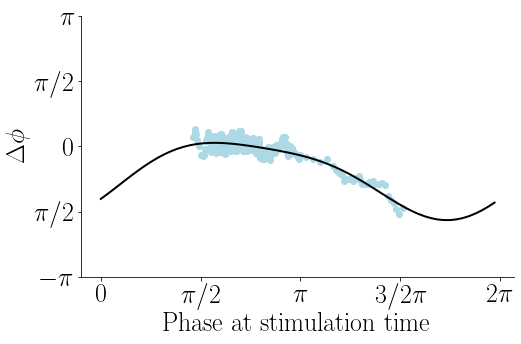

In [40]:
#1/(T0*10**-3), 1/(T1*10**-3)

plt.scatter(unii,mean,c = 'lightblue', marker = 'o')
theta = np.arange(0,2*np.pi,0.1)
plt.plot(theta, a0 + a1*np.cos(theta) + a2*np.cos(2*theta)+  b1*np.sin(theta) + b2*np.sin(2*theta), 'k', lw = 2 )
#plt.plot(theta, a01 + a11*np.cos(theta) + a21*np.cos(2*theta)+  b11*np.sin(theta) + b21*np.sin(2*theta),color = 'orange' )

plt.xticks(np.arange(0,2*np.pi + np.pi/2,np.pi/2), labels = ["0", "$\pi/2$","$\pi$","$3/2\pi$","$2\pi$"])
plt.yticks(np.arange(-np.pi,np.pi + np.pi/2,np.pi/2), labels = ["$-\pi$","$\pi/2$","$0$","$\pi/2$","$\pi$"])
plt.xlabel('Phase at stimulation time')
plt.ylabel(r'$\Delta \phi$');
#plt.savefig('Fig/PRC2s.jpg', dpi = 300, bbox_inches ='tight')

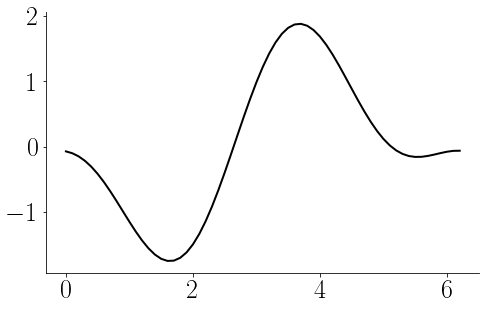

In [247]:
plt.plot(theta, a0 + a1*np.cos(theta) + a2*np.cos(2*theta)+  b1*np.sin(theta) + b2*np.sin(2*theta), 'k', lw = 2 )


## Building a model of one oscillator with that PRC

In [206]:
np.save('myprc.npy',np.array([a0,a1,a2,b1,b2]))


In [95]:
a0,a1,a2,b1,b2 = np.load('myprc.npy')

In [96]:
import numpy as np

In [169]:
cd '/home/benny/Desktop/Github/Oscillations analysis/'

/home/benny/Desktop/Github/Oscillations analysis


In [5]:
myprc = np.load('myprc.npy')

In [97]:
def myPRC(theta,a0,a1,a2,b1,b2):
        return a0 + a1*np.cos(theta) + a2*np.cos(2*theta)+  b1*np.sin(theta) + b2*np.sin(2*theta)


In [98]:
from numba import njit

@njit
def myOscill(T,dt, omega_0, epsilon,a0,a1,a2,b1,b2):
    def myPRC(theta,a0,a1,a2,b1,b2):
        return a0 + a1*np.cos(theta) + a2*np.cos(2*theta)+  b1*np.sin(theta) + b2*np.sin(2*theta)
    N = int(T/dt)
    x = np.zeros(N)
    for t in range(N-1):
        x[t+1]= (x[t] + (omega_0 + epsilon[t]*myPRC(x[t],a0,a1,a2,b1,b2))*dt)%(2*np.pi)
    return x

In [225]:
myprc.max()*1000


1881.5884072209954

In [117]:
T = 2000
dt = 0.001
N = int(T/dt)
times = np.array(np.arange(0,N,10000) + np.array(np.random.randn(len(np.arange(0,N,10000)))*600, dtype = int),dtype = int)
epsilon = np.zeros(N)
for r in range(N):
    if r in times:
        epsilon[r] = 400 #?
x =  myOscill(T,dt,3, epsilon,a0,a1,a2,b1,b2)

(0.0, 10000.0)

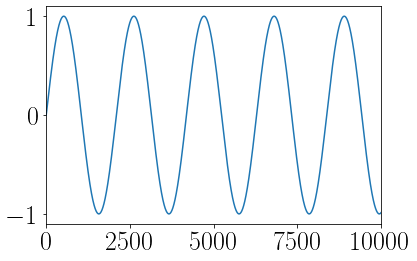

In [113]:
plt.plot(np.sin(x))
plt.vlines(times,-1,1,'r')
plt.xlim(0,10000)

In [222]:
len(sig)

2215

In [120]:
phasestim = []
phases = []
#t_s = 1110

for t in times[3:]:
    t_s = 6000
    sig = np.cos(x[t-6000:t+5000])
    peaks =R_helper_detector(sig)
    #print(peaks)
    #print(peaks.shape)
    
    if t < 30000:
        plt.figure()
        plt.plot(sig, 'orange', alpha = 0.3)
        
        plt.plot(peaks[:,0],peaks[:,1], 'ro')
        plt.vlines(t_s,-2,2, 'r', lw = 2)
        #plt.xlim(1000,1500)
    
    idx = np.where( (t_s- peaks[:,0]) == (t_s- peaks[:,0])[(t_s- peaks[:,0])>0].min())[0][0]
    time = peaks[:,0][idx]
    ts = t_s - time
    #t_s = 1110
    T0 =[]
    for r in range(len(peaks[:idx])):
        #print(len(peaks[:idx-1]))
        T0.append(peaks[:,0][idx-r] - peaks[:,0][idx -1-r])

    T0 = np.array(T0).mean()
    T1 = peaks[:,0][idx + 1] - peaks[:,0][idx]
    phase = (T0 - T1)/T0*2*np.pi
    phase_stim = ts/T0*2*np.pi
    phasestim.append(np.sign(phase_stim)*(np.abs(phase_stim)%(2*np.pi)))
    phases.append(np.angle(np.exp(1j*phase)))

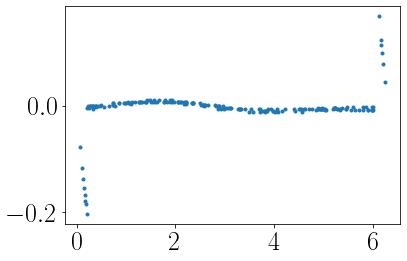

In [121]:
plt.plot(phasestim,phases, '.')

(197,) (197,)


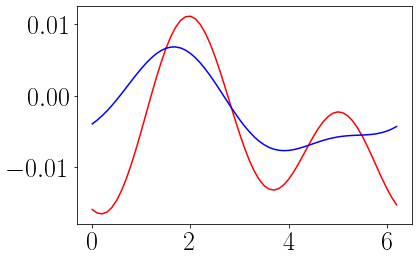

In [122]:
y = np.array(phases)
phasestim = np.array(phasestim)
print(phasestim.shape,y.shape)
oss01 = np.ones((len(phasestim)))
oss1 = np.cos(phasestim)
oss2 = np.cos(2*phasestim)
#oss02 = np.ones((len(unii)))
oss3 = np.sin(phasestim)
oss4 = np.sin(2*phasestim)

X = np.vstack((oss1,oss2,oss3,oss4,oss01)).T
a11,a21,b11,b21,a01= (np.linalg.inv(X.T @ X) @ X.T) @ y
theta = np.arange(0,2*np.pi,0.1)
#plt.plot(phasestim,phases, 'r.')
plt.plot( theta, myPRC(theta,a01,a11,a21,b11,b21), 'r')
#theta = np.arange(-np.pi,np.pi,0.1)
plt.plot(theta, myPRC(theta,a0,a1,a2,b1,b2)*10**-0.5, 'b')
###'cè uno shift di p/2 a second di da dove si comincia a studiare fase!)


In [434]:
0.1*100

10.0

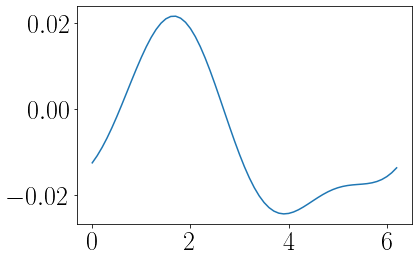

In [104]:
def myPRC(theta,a0,a1,a2,b1,b2):
    return a0 + a1*np.cos(theta) + a2*np.cos(2*theta)+  b1*np.sin(theta) + b2*np.sin(2*theta)
plt.plot(np.arange(0,np.pi*2,0.1), myPRC(np.arange(0,np.pi*2,0.1),a0,a1,a2,b1,b2));

## FIltrando nella banda dei 6 Hz

In [56]:
dt = 10/9764
sf = 1/dt

down = 1
up = 100
nyq = 0.5*sf

lowcut = 6- 1
highcut = 6 +1
low = lowcut / nyq
high = highcut / nyq
order = 2


sig = timeseries[:,:,:]

n = 100
Wn = [lowcut,highcut]
b = firwin(n, Wn,pass_zero=False,fs = sf) 
filtered2  = filtfilt(b, 1, sig,axis = 1)
f, h = signal.butter(order,[low, high], btype='bandpass')
filtered = signal.filtfilt(f, h, sig, axis = 1,padlen=150)

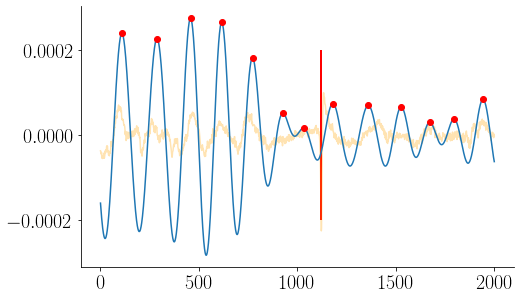

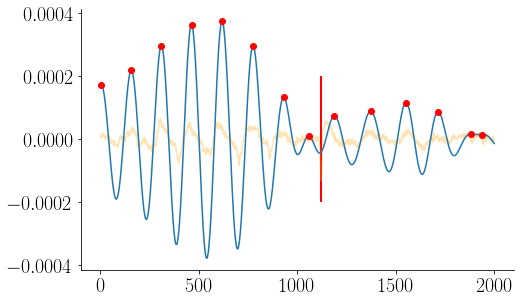

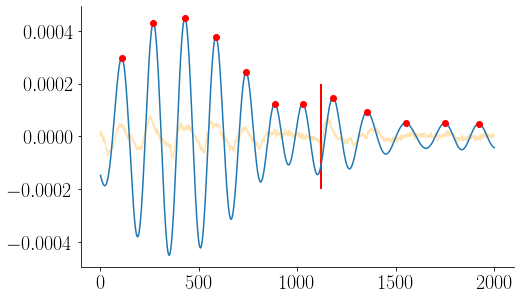

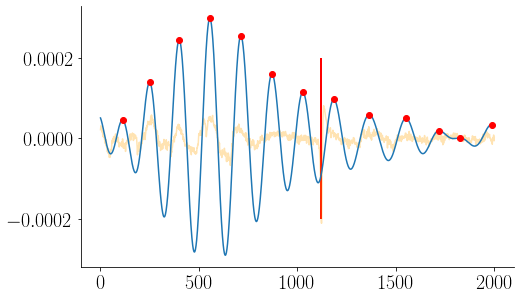

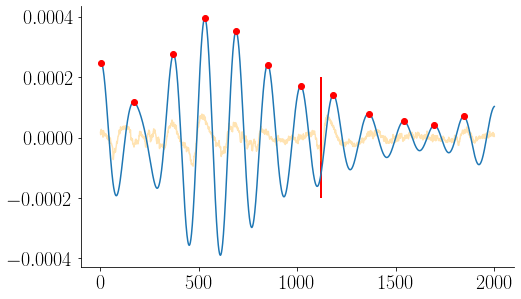

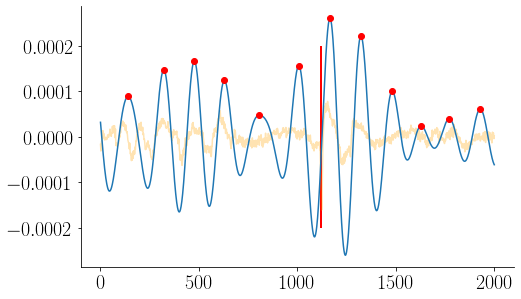

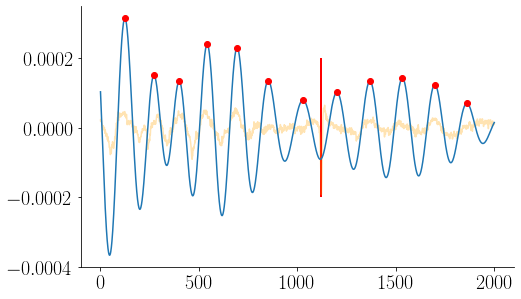

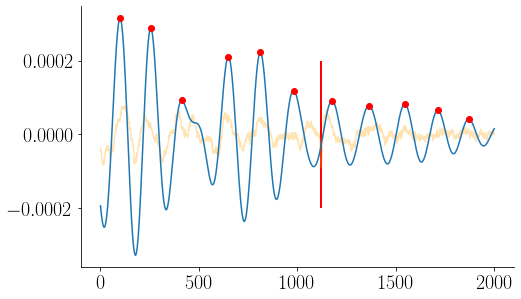

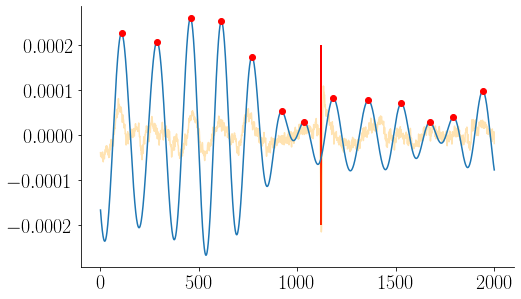

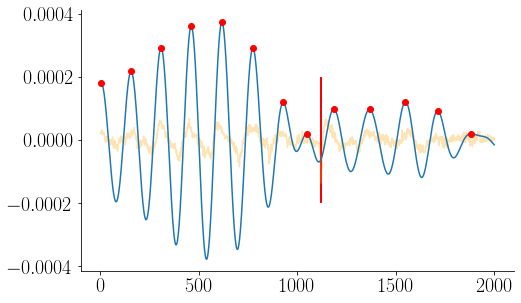

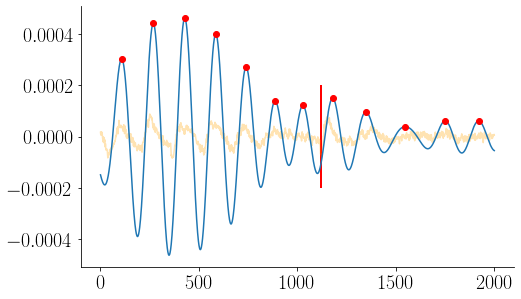

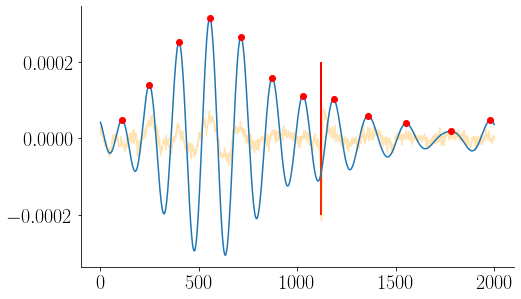

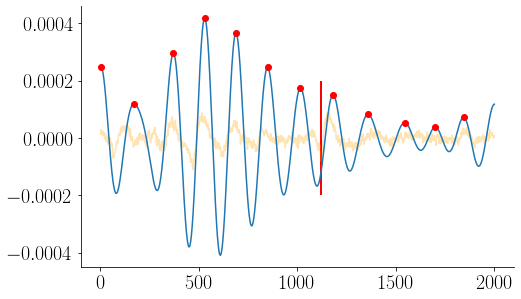

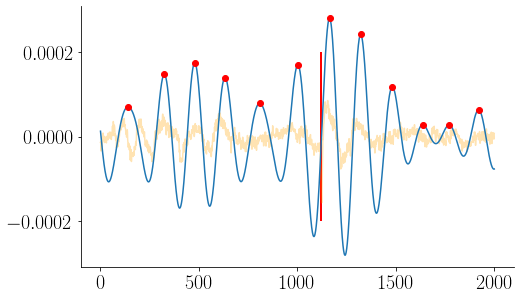

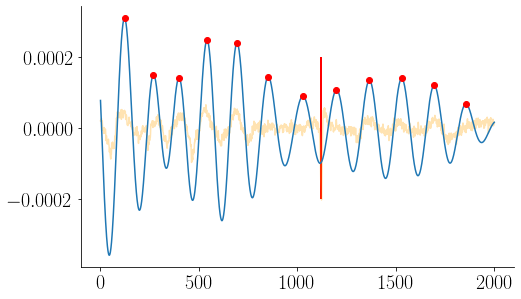

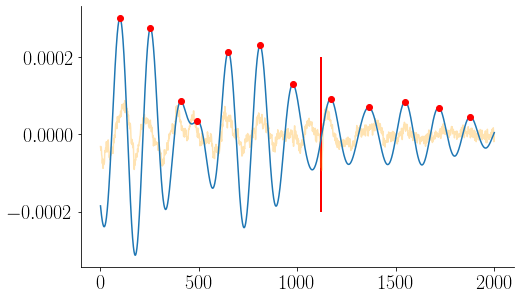

In [61]:
## Non molto significativo per colpa del dataset
phasestim = []
phases = []
t_s = 1110


for elect in range(61,63):
    for trial in range(20):
        peaks =R_helper_detector(filtered[trial,1000:3000,elect])
        #print(peaks.shape)
        
        if trial < 8:
            plt.figure()
            plt.plot(sig[trial,1000:3000,elect]*10**-1, 'orange', alpha = 0.3)
            plt.plot(filtered[trial,1000:3000, elect])
            plt.plot(peaks[:,0],peaks[:,1], 'ro')
            plt.vlines(1118,-0.0002,0.0002, 'r', lw = 2)
            #plt.xlim(1000,1500)
        
        
        idx = np.where( (t_s- peaks[:,0]) == (t_s- peaks[:,0])[(t_s- peaks[:,0])>0].min())[0][0]
        time = peaks[:,0][idx]
        ts = t_s - time
        #t_s = 1110
        T0 =[]
        for r in range(len(peaks[:idx])):
            #print(len(peaks[:idx-1]))
            T0.append(peaks[:,0][idx-r] - peaks[:,0][idx -1-r])
            
        T0 = np.array(T0).mean()
        T1 = peaks[:,0][idx + 1] - peaks[:,0][idx]
        phase = (T0 - T1)/T0*2*np.pi
        phase_stim = ts/T0*2*np.pi
        phasestim.append(np.sign(phase_stim)*(np.abs(phase_stim)%(2*np.pi)))
        phases.append(np.sign(phase)*(np.abs(phase)%(2*np.pi)))

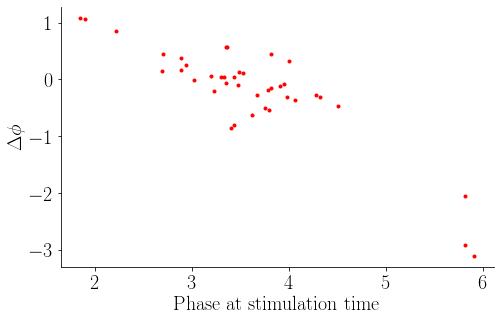

In [62]:
#1/(T0*10**-3), 1/(T1*10**-3)
plt.plot(phasestim,phases, 'r.')
plt.xlabel('Phase at stimulation time')
plt.ylabel(r'$\Delta \phi$');

## Doing the same thing on a model

In [251]:
from numba import njit

In [252]:

@njit
def oscill(T, dt, trials, phas, currents):
    def H(a0,a1,a2,b0,b1,b2,theta):
        return a0*np.cos(0*theta) + a1*np.cos(1*theta)+ a2*np.cos(2*theta) + b0*np.sin(0*theta) +  b1*np.sin(1*theta) + b2*np.sin(2*theta) 

    N = int(T/dt)
    thetas = np.zeros((trials,N,2))*2*np.pi
    thetas0 = np.random.random((2))*2*np.pi
    
    omega = np.array([3,8])
    K = 1
    for s in range(trials):
        thetas[s,0] = thetas0
        for r in range(N-1):  
            thetas[s,r + 1,0] = (thetas[s,r,0] + omega[0]*dt + currents[s,r]*K*H(0,0,0.,0.,np.pi,0.,thetas[s,r,1] - thetas[s,r,0]+ phas[s,r])*dt)%(2*np.pi)
            thetas[s,r + 1,1] = (thetas[s,r,1] + omega[1]*dt +  currents[s,r]*K*H(0,0,0.,0.,np.pi,0.,thetas[s,r,0] - thetas[s,r,1])*dt)%(2*np.pi)
    return thetas

In [135]:
len(thetas[0])

30000

In [266]:
trials = 1000
T0 = 2131
N = T0*7
T = int(N*dt)
dt = 0.001
N =int(T/dt)
times = []
phas = np.zeros((trials,N))
currents =  np.ones((trials,N))*0.1
for r in range(trials):
    f = np.random.randint(0,T0)
    times.append(int(T0*4)+f)
    phas[r, int(T0*4) + f] = np.pi
    currents[r, int(T0*4) + f] = 30

In [267]:
thetas = oscill(T,dt,trials,phas,currents)

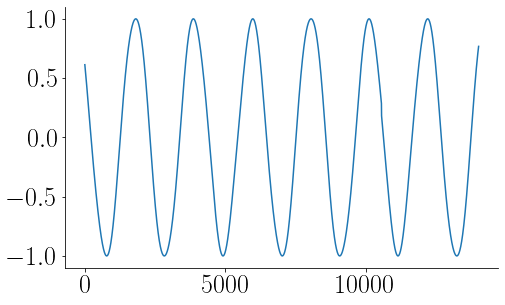

In [268]:
plt.plot(np.sin(thetas[0,:,0]))

In [128]:
# K andrebbe fittato e non lasciato come parametro libero?
# non mi viene phase response curve sinusoidale...
# forse mio meodo di peak detection non funziona molto bene?

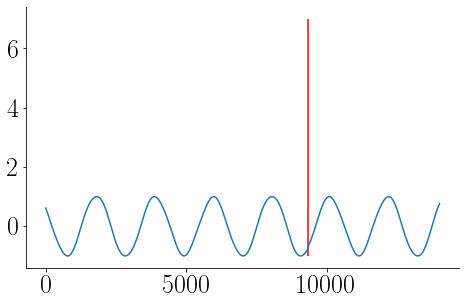

In [269]:
#plt.plot((theta[:,0]))
#plt.vlines(times[0],-1,7, 'r')
#plt.plot(np.sin(thetas[0,:,1]))
#plt.plot((theta[:,0]))
#plt.vlines(times[1],-1,7, 'r')
#plt.plot(np.sin(thetas[1,:,1]))


plt.vlines(times[2],-1,7, 'r')
plt.plot(np.sin(thetas[2,:,0]))
#plt.xlim(0,11000)

In [389]:
t_s

2000

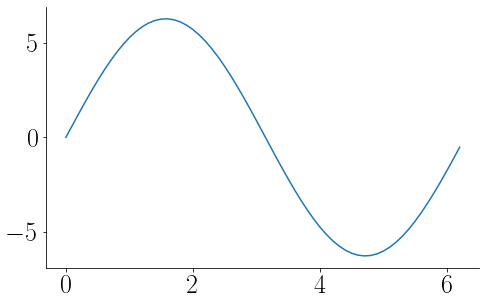

In [270]:
angoli = np.arange(0,2*np.pi,0.1)
plt.plot(angoli, H(0,0,0,0,2*np.pi,0,angoli))

In [146]:
2*np.pi/(2131*10**-3)

2.94846799961501

(18, 2)
12
786.75
796.0
(18, 2)
786.4
812.0


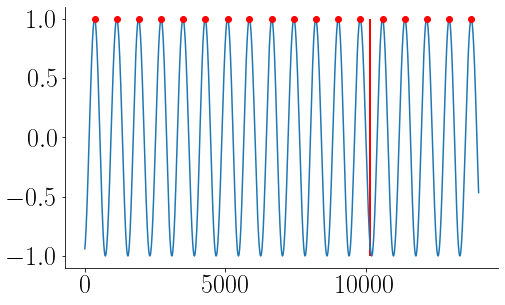

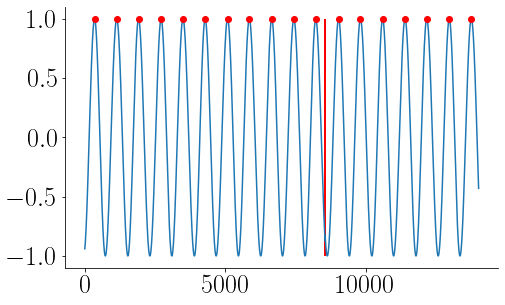

In [271]:
trial =3
t_s = times[trial]

#t_s = 2000
#trial = 0
peaks =R_helper_detector(np.sin(thetas[trial,:,1]))
print(peaks.shape)
#if trial < 8:
plt.figure()
plt.plot(np.sin(thetas[trial,:,1]))
plt.plot(peaks[:,0],peaks[:,1], 'ro')
 #plt.plot(sig[1000:3000,80]*10**-1, 'orange')
plt.vlines(t_s,-1,1, 'r', lw = 2)
#plt.xlim(1000,1500)

idx = np.where( (t_s- peaks[:,0]) == (t_s- peaks[:,0])[(t_s- peaks[:,0])>0].min())[0][0]
time = peaks[:,0][idx]
ts = t_s - time
#t_s = 1118
T0 = []
print(len(peaks[:idx]))
for r in range(len(peaks[:idx])):
    T0.append(peaks[:,0][idx-r] - peaks[:,0][idx -1-r])


T0 = np.array(T0).mean()
T1 = peaks[:,0][idx + 1] - peaks[:,0][idx]

print(T0)
print(T1)
phase = (T0 - T1)/T0*2*np.pi
phase_stim = ts/T0*2*np.pi






trial =10
t_s = times[trial]
#plt.plot(thetas[trial,:,1])
#t_s = 2000
#trial = 0
peaks =R_helper_detector(np.sin(thetas[trial,:,1]))
print(peaks.shape)
#if trial < 8:
plt.figure()
plt.plot(np.sin(thetas[trial,:,1]))
plt.plot(peaks[:,0],peaks[:,1], 'ro')
 #plt.plot(sig[1000:3000,80]*10**-1, 'orange')
plt.vlines(t_s,-1,1, 'r', lw = 2)
#plt.xlim(1000,1500)

idx = np.where( (t_s- peaks[:,0]) == (t_s- peaks[:,0])[(t_s- peaks[:,0])>0].min())[0][0]
time = peaks[:,0][idx]
ts = t_s - time
#t_s = 1118
T0 = []

for r in range(len(peaks[:idx])):
    T0.append(peaks[:,0][idx-r] - peaks[:,0][idx -1-r])


T0 = np.array(T0).mean()
T1 = peaks[:,0][idx + 1] - peaks[:,0][idx]

print(T0)
print(T1)
phase = (T0 - T1)/T0*2*np.pi
phase_stim = ts/T0*2*np.pi



In [215]:
np.sin(0.5*np.pi + 2)

-0.41614683654714235

In [93]:
# come si lega phase response curve a un modello del genere

1.5707963267948966

In [272]:
phasestim = []
phases = []

#for elect in range(60,65):
for trial in range(thetas.shape[0]):
    peaks =R_helper_detector(np.cos(thetas[trial,:,1]))
    
    t_s = times[trial]
    #print(peaks.shape)
    #if trial < 8:
    #    plt.figure()
    #    plt.plot(trials[trial,:,1])
    #    plt.plot(peaks[:,0],peaks[:,1], 'ro')
         #plt.plot(sig[1000:3000,80]*10**-1, 'orange')
    #    plt.vlines(t_s,-1,1, 'r', lw = 2)
        #plt.xlim(1000,1500)

    idx = np.where( (t_s- peaks[:,0]) == (t_s- peaks[:,0])[(t_s- peaks[:,0])>0].min())[0][0]
    time = peaks[:,0][idx]
    #print(time)
    ts = t_s - time
    #t_s = 1118
    T0 = []
    for r in range(len(peaks[:idx])):
        T0.append(peaks[:,0][idx-r] - peaks[:,0][idx -1-r])

    T0 = np.array(T0).mean()
    T1 = peaks[:,0][idx + 1] - peaks[:,0][idx]
    #print(T0 > T1)
    phase = (T0 - T1)/T0*2*np.pi
    phase_stim = ts/T0*2*np.pi
    #print(np.sign(phase) > 0)
    phasestim.append(np.sign(phase_stim)*(np.abs(phase_stim)%(2*np.pi)))
    phases.append(np.sign(phase)*(np.abs(phase)%(2*np.pi)))
    
    #phasestim.append((np.abs(phase_stim)%(2*np.pi)))
    #phases.append((np.abs(phase)%(2*np.pi)))

In [406]:
# -2pi e 2pi sono uguali

In [275]:
y = np.array(phases)
phasestim = np.array(phasestim)
oss01 = np.ones((len(phasestim)))
oss1 = np.cos(phasestim)
oss2 = np.cos(2*phasestim)
#oss02 = np.ones((len(unii)))
oss3 = np.sin(phasestim)
oss4 = np.sin(2*phasestim)

X = np.vstack((oss1,oss2,oss3,oss4,oss01)).T
a10,a20,b10,b20,a00= (np.linalg.inv(X.T @ X) @ X.T) @ y

In [273]:
def myPRC(theta,a0,a1,a2,b1,b2):
    return a0 + a1*np.cos(theta) + a2*np.cos(2*theta)+  b1*np.sin(theta) + b2*np.sin(2*theta)
def H(a0,a1,a2,b0,b1,b2,theta):
        return a0*np.cos(0*theta) + a1*np.cos(1*theta)+ a2*np.cos(2*theta) + b0*np.sin(0*theta) +  b1*np.sin(1*theta) + b2*np.sin(2*theta) 

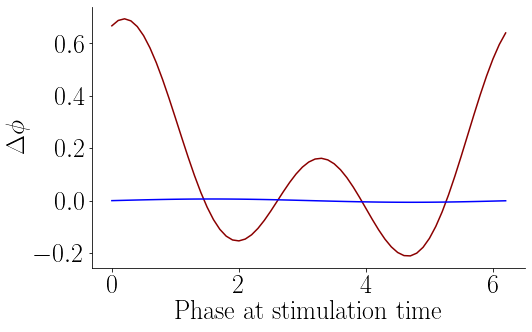

In [276]:
# ?
theta = np.arange(0,2*np.pi,0.1)
plt.plot(theta, myPRC(theta,a00,a10,a20,b10,b20), color ='darkred')
#plt.plot(phasestim,phases, '.')
plt.plot(theta,H(0,0,0.,0.,2*np.pi,0.,theta)*10**-3,'b')
plt.xlabel('Phase at stimulation time')
plt.ylabel(r'$\Delta \phi$');
#plt.xlim(0,np.pi*2)
#plt.xticks(np.arange(0,2*np.pi,np.pi/2))
#plt.yticks(np.arange(-np.pi,np.pi,np.pi/2));
#plt.xticks(np.arange(0,np.pi*2 + np.pi/2,np.pi/2), labels = ["0", "$\pi/2$","$\pi$","$3/2\pi$","$2\pi$"])
#plt.yticks(np.arange(-np.pi,np.pi + np.pi/2,np.pi/2), labels = ["$-\pi$","$\pi/2$","$0$","$\pi/2$","$\pi$"]);
#plt.ylim(-0.1,0.1)